In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 04: ALE plots
Use the trained base model to explore interaction measures.  ALE plots.  Do:
  * 2-way (interaction) plots, same pairs as in Friedman's H
  * Summarize 2 way interaction strength
    * This is done by getting the average or median ALE value, so each ALE value is weighted by counts in its bucket. 
    * For 1-way ALE, counts are provided.  For 2-way ALE I estimate them. 
    * This provides a way to roughly compare overall interaction strengths.
  * Selected 1-way plots & selected analysis

*This script takes about 3 minutes to run on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, importlib
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import warnings
import time
import wquantiles
from IPython.display import Image

In [3]:
from PyALE import ale

In [4]:
from interactions_package.interactions_package import ip_plot
ip_plot.plot_defaults()

## Import Data

##### Predictors

In [5]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv'))['feature'].tolist()

##### Dataset - use sample of training data

In [6]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet'))

##### Model

In [7]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

##### Permutation importances

In [8]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

##### Friedman's H Scores

In [9]:
h_comb = pd.read_csv(Path(setup.temp_path).joinpath('03_DATA_h_scores.csv'))

## 2-Way ALE Plots
  * Create line plots
  * Quantify overall contributuons using approximate bin counts

### Functions for retrieving 2-way data, plotting, and quantifying

In [10]:
# Function to guess at bucket boundaries in the ALE data

In [11]:
def get_bucket_edges_from_centers(center_list,
                                 left_edge=np.NINF,
                                 right_edge = np.inf):
    """ Given a list of bucket centers, get edges as midpoints
    between these. Append the left and right edges if needed. 
    Left and right edges can be set to None to ignore. These
    edges will be used in pandas.cut.
      Inputs:
          center_list: List of center points for the intervals
          left_egde:  Left edge to prepend to the edge list
          right_edge:  Right edge to append to the edge list
      Value:  
          List of bucket edges
    """
    
    midpoint_list = [(center_list[i] + center_list[i+1])/2 \
                      for i in range(0, len(center_list) -1)]
    if (left_edge is not None) and right_edge is not None:
        return [left_edge] + midpoint_list + [right_edge]
    elif left_edge is not None:
        return [left_edge] + midpoint_list
    elif right_edge is not None:
        return midpoint_list + [right_edge]
    else:
        return midpoint_list

In [12]:
# Function to get the counts in the buckets used in the ALE data
# the 2-way PyALE.ale function does not return these and so I
# estimate them.  They may not be exact but should be close.

In [13]:
def ale_2way_counts(ale_data, features_data):
    """ Get approximate counts in the 2D ALE buckets in the
    features dataset.  Find edges of buckets whose centers 
    are the rows and columns of the dataset, and then count
    features dataset rows in that bucket.
       The purpose of this function is to get an idea of the
    volume of points corresponding to given ALE interactions 
    strengths.  
      Inputs:
        ale_data:  2-way ALE data from PyALE.ale
        features_data:  Pandas dataframe containing thje
           dataset used to generate the ALE data (or a related
           dataset).  The data frame must contain the features
           in ale_data
      Value:  
          Pandas dataframe containing counts in the ALE buckets
    """
    feature_1 = ale_data.index.name
    feature_2 = ale_data.columns.name
    
    # Put first feature into buckets
    bucket_centers_1 = list(ale_data.index)
    bins_1 = get_bucket_edges_from_centers(bucket_centers_1)
    bucket_1 = pd.cut(features_data[feature_1], bins=bins_1,
                      labels = bucket_centers_1)
    
    # Put second feature into buckets
    bucket_centers_2 = list(ale_data.columns)
    bins_2 = get_bucket_edges_from_centers(bucket_centers_2)
    bucket_2 = pd.cut(features_data[feature_2], bins=bins_2,
                      labels = bucket_centers_2)
    
    # Get data frame for counting
    bucket_long = pd.concat([bucket_1, bucket_2], axis=1)
    bucket_long['count'] = 1
    
    # Count and pivot
    count_df = bucket_long \
        .groupby([feature_1, feature_2])['count'] \
        .agg('sum') \
        .reset_index() \
        .sort_values([feature_1, feature_2]) \
        .pivot(index=feature_1, columns=feature_2)
    
    return count_df

In [14]:
# Functions for getting weighted averages/medians of ALE plot values

In [15]:
def ale_2way_magnitude(ale_data, count_data):
    """ Gets the average absolute value of a 2 way ALE dataset,
    given the bucket counts for each cell"""
    norm_counts = count_data.values / np.sum(count_data.values)
    return np.sum((np.abs(ale_data).values) * norm_counts)

In [16]:
def ale_2way_median_abs(ale_data, count_data):
    """ Gets the median absolute value of a 2 way ALE dataset,
    using the cell bucket counts as a weight """
    return wquantiles.median(np.abs(ale_data.values.flatten()), 
                             count_data.values.flatten())

### Calculate 2 Way ALE Plots and Magnitudes
 * Create a folder for holding the ALE plot
 * For each feature pair we looked at for Friedman's H, plot the 2 way ALE and get the mean absolute interaction strength. 

##### Create results folder, as we will create a lot of plots

In [17]:
ale_folder = Path(setup.temp_path) \
    .joinpath('04_PLOT_ALE_2WAY')

In [18]:
ale_folder.mkdir(parents=True, exist_ok=True)

##### Get ALE Values

In [19]:
# Function for creating the plots for one set of features
def do_plot_2way(X, model, feature_1, feature_2,
                output_path = None,
                grid_size = 25):
    
    # Get the ALE data.  This function may fail for very weak features.
    
    try:
        t_init = time.process_time()
        this_ale = ale(X=X, model=model, feature=[feature_1, feature_2], 
                       grid_size = grid_size, plot=False)
        total_time = time.process_time() - t_init
    except:
        return None
       
    # Get the counts and abs mean interaction strength
    this_count = ale_2way_counts(this_ale, X)
                      
    # Get the abs mean interaction strength
    abs_mean =  ale_2way_magnitude(this_ale, this_count)
    abs_median = ale_2way_median_abs(this_ale, this_count)
        
    # Create the plot
    this_fig = ip_plot.ale_2way_plot(this_ale, title='features', title_prefix='2-Way ALE:  ')
    
    # Optionally save the plot
    if output_path is not None:
        this_fig.savefig(output_path, bbox_inches='tight')
    plt.close(this_fig)
    
    return (abs_mean, abs_median, total_time)

##### Save plots and get magnitudes for all feature pairs

In [61]:
importlib.reload(ip_plot)

<module 'interactions_package.interactions_package.ip_plot' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/code/interactions_package/interactions_package/ip_plot.py'>

In [62]:
%%capture 

ale_mag_ser = h_comb[['feat_1', 'feat_2']] \
    .apply(lambda x: do_plot_2way(train_samp_df[predictor_features], base_model,
                                  x.feat_1, x.feat_2,
                                  output_path = ale_folder \
                                      .joinpath('__'.join(['plot', x.feat_1, x.feat_2]))),
          axis=1)

In [63]:
ale_mag_df = pd.concat([h_comb[['feat_1', 'feat_2']],
                        pd.DataFrame([[a, b, c] for a,b,c in ale_mag_ser.values],
                                     columns=['abs_mean', 'abs_median', 'time'])],
                       axis=1)

In [64]:
ale_mag_df['label'] = ale_mag_df['feat_1'] + ':' + ale_mag_df['feat_2']

In [65]:
ale_mag_df = ale_mag_df.sort_values('abs_mean', ascending=False)

In [66]:
ale_mag_df.head()

,feat_1,feat_2,abs_mean,abs_median,time,label
12,int_rate,term,0.013039,0.008948,1.480428,int_rate:term
29,int_rate,loan_amnt,0.012732,0.007961,0.998682,int_rate:loan_amnt
21,int_rate,sec_app_fico_range_low,0.010854,0.009182,0.780660,int_rate:sec_app_fico_range_low
39,int_rate,home_ownership__RENT,0.008795,0.006123,1.588491,int_rate:home_ownership__RENT
37,int_rate,annual_inc,0.008668,0.005948,0.900146,int_rate:annual_inc


In [67]:
ale_mag_df.to_csv(Path(setup.temp_path) \
                      .joinpath('04_DATA_ale_magnitudes_2way.csv'), 
                  index=False)

In [68]:
# Save time info
time_df = pd.DataFrame({'time': ale_mag_df['time'].sum(),
                        'case_count': [len(train_samp_df)],
                        'feature_count': [len(h_comb) * 2]})
time_df['time_per_case'] = time_df['time'] / time_df['case_count']
time_df.to_csv(Path(setup.temp_path).joinpath('04_REPORT_timing_ale_scores.csv'))

In [69]:
time_df

,time,case_count,feature_count,time_per_case
0,49.77126,100000,90,0.000498


## Plot Mean Abs Interaction Strength

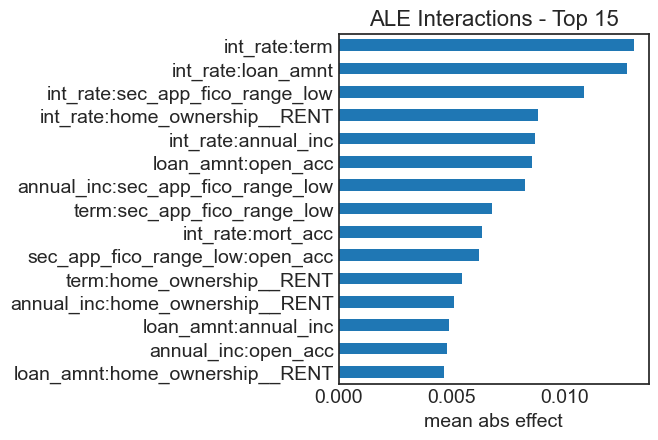

In [70]:
fig = ip_plot.plot_basic_bar(ale_mag_df, 'abs_mean', n_bars=15,
                           label='label', title='ALE Interactions - Top 15',
                           ylabel='mean abs effect')
fig.savefig(Path(setup.temp_path).joinpath('04_PLOT_ale_pairs.png'),
                 bbox_inches='tight')

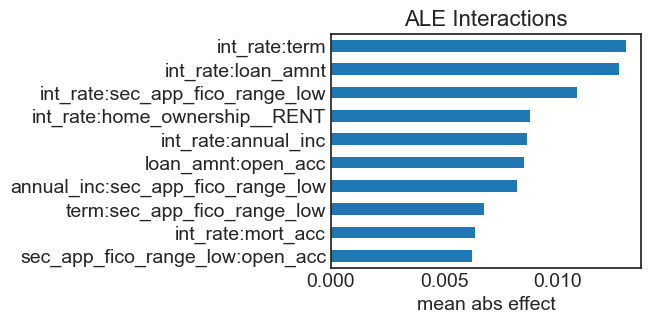

In [71]:
fig = ip_plot.plot_basic_bar(ale_mag_df, 'abs_mean', 
                           label='label', title='ALE Interactions',
                           ylabel='mean abs effect')
fig.savefig(Path(setup.temp_path).joinpath('04_PLOT_ale_pairs_top_10.png'),
                 bbox_inches='tight')

## Plot Median Abs Interaction Strength

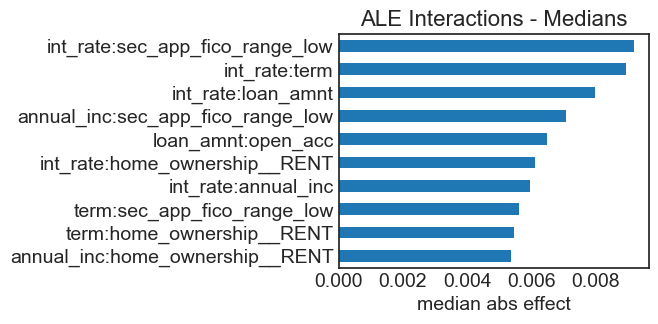

In [72]:
fig = ip_plot.plot_basic_bar(ale_mag_df, 'abs_median', 
                           label='label', title='ALE Interactions - Medians',
                           ylabel='median abs effect',
                           do_sort = True)
fig.savefig(Path(setup.temp_path).joinpath('04_PLOT_ale_pairs_median_top_10.png'),
                 bbox_inches='tight')

## 1-Way Plots and Magnitiudes
  * These will be used as part of the discussion of interaction for specific cases.
  * I also will save the magnitudes to compare the relative strengths of the interaction portions with the main effect portions
  * I use the default ALE plots, but change the axis scaling as needed, as well as some axis labels

##### Create results folder, as we will create a lot of plots

In [32]:
ale_1way_folder = Path(setup.temp_path).joinpath('04_PLOT_ALE_1WAY')
ale_1way_folder.mkdir(parents=True, exist_ok=True)

##### Function to do the plots and return the magnitudes for each feature

In [33]:
# Function for creating the plots for one set of features
def do_plot_1way(X, model, feature,
                output_path = None,
                grid_size = 20):
    
    # Get the ALE data.  This function may fail for very weak features.
    
    fig, ax = plt.subplots()
    
    try:
        this_ale_1way = ale(X=X, model=model, feature=[feature], plot=True,
                           fig=fig, ax=ax, grid_size = grid_size)
    except:
        return None
    
    # Normalize to get magnitudes
    this_norm_counts = this_ale_1way['size'] / np.sum(this_ale_1way['size'])
    this_mag = np.sum(this_ale_1way['eff'].apply(np.abs) * this_norm_counts) 
    
    # Modify the plot - auto detect log scale
    x_scale = ip_plot.plot_default_scale(this_ale_1way.index)
    if (x_scale == 'log'):
        x_label = ax.get_xlabel()
        x_label = x_label + ' (log scale)'
        ax.set_xscale(x_scale)
        ax.set_xlabel(x_label)
        
    # Set the plot title
    plt.title('1-Way ALE: ' + feature)
    
    # Fix issue with too many ticks sometimes
    if len(ax.get_xticklabels()) > 15:
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    
    # Optionally save the plot 
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')
    plt.close(fig)
    
    return this_mag

##### Save plots and get magnitudes for all feature pairs

In [34]:
%%capture 

ale_mag_ser_1way = pd.Series(predictor_features) \
    .apply(lambda x: do_plot_1way(train_samp_df[predictor_features], base_model, x,
                                  output_path = ale_1way_folder.joinpath('plot__' + x)))

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.


In [35]:
ale_mag_1way_df = pd.concat([pd.Series(predictor_features), ale_mag_ser_1way],
                            axis=1) \
    .set_axis(['feat', 'abs_mean'], axis=1) \
    .sort_values('abs_mean', ascending=False)

In [36]:
ale_mag_1way_df.to_csv(Path(setup.temp_path) \
                           .joinpath('04_DATA_ale_magnitudes_1way.csv'), 
                       index=False)

##### Plot 1 way ALE effect magnitudes

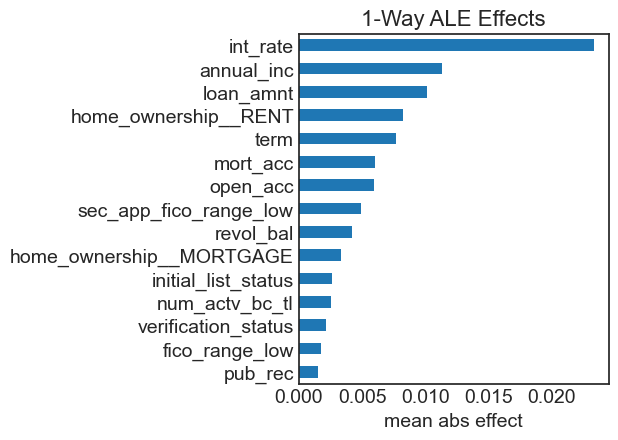

In [37]:
fig = ip_plot.plot_basic_bar(ale_mag_1way_df, 'abs_mean', n_bars=15, 
                           label='feat', title='1-Way ALE Effects',
                           ylabel='mean abs effect')
fig.savefig(Path(setup.temp_path).joinpath('04_PLOT_ale_1way_effects.png'),
                 bbox_inches='tight')

## Selected Plots

##### Term and Interest Rate
Here, we see a dramatic difference compared to the ALE plot, and counter-intuitive results that shorter terms are protective at high interest rates

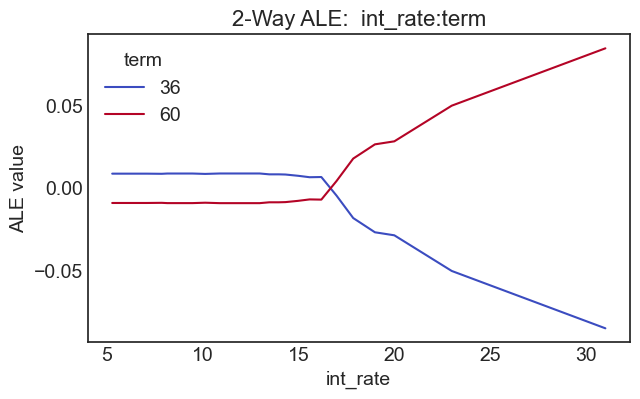

In [73]:
Image(ale_folder.joinpath('plot__int_rate__term.png'))

The above plot shows fairly similar, low magnitude curves below an interset rate of ~17, but above that interactions increase dramatically and the curves diverge.  A high interest rate plus a long term greatly increases default risk.

Let's look at the main effects

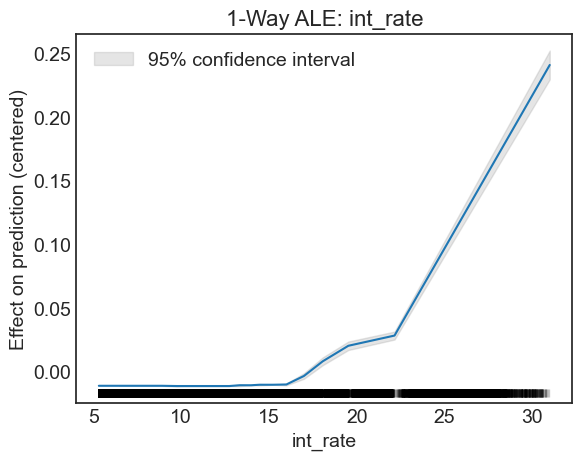

In [39]:
Image(ale_1way_folder.joinpath('plot__int_rate.png'), width=380)

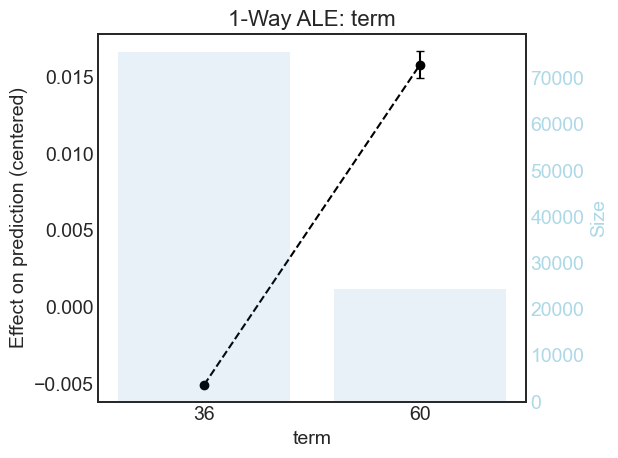

In [40]:
Image(ale_1way_folder.joinpath('plot__term.png'), width=380)

The main effets of interest rate at high values are much stronger than interaction effects.  The term main effect is comparitively weak.

It appears that term enhances risk at high interest rates but does not have a dramatic main effect.

##### Term and Second Applicant FICO
Here we see higher risk when the second applicant has very bad credit, but the effect depends on term.  A long loan term magnifies the risk of the 2nd applicant's credit (in the model).

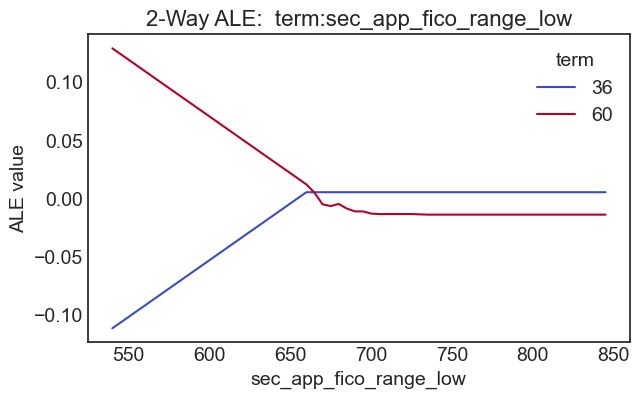

In [41]:
Image(ale_folder.joinpath('plot__term__sec_app_fico_range_low.png'))

The above plot shows that the prediction is strongly affected for low 2nd FICO scores.  Let's look at the one way effects

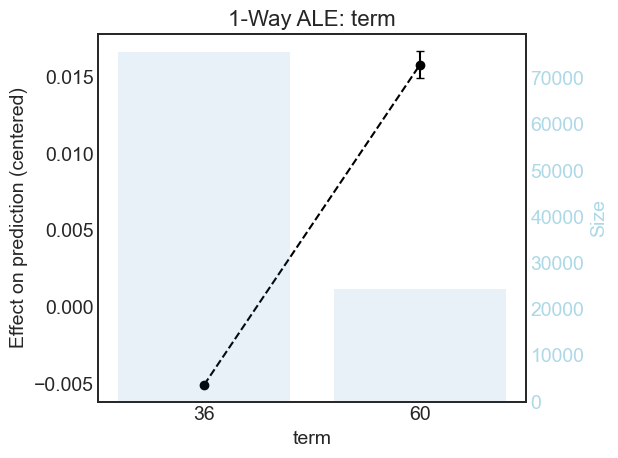

In [42]:
Image(ale_1way_folder.joinpath('plot__term.png'), width=380)

The range of values for the 1 way term plot is about 0.02, whereas the range for the 2way plot is similar, so the interaction is greater than the term main effect.

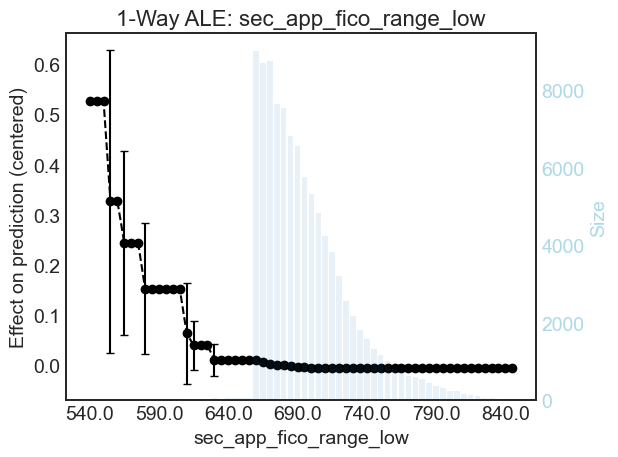

In [43]:
Image(ale_1way_folder.joinpath('plot__sec_app_fico_range_low.png'), width=380)

The second FICO score has a larger main effect at low values.  The interaction reduces the penalty for lower terms and increases it for higher terms.

##### Interest Rate and Loan Amount
Here we see a very expected situation, where high interest rate is risky, and large loan amounts are risky.  But at the very highest interest rate, risk varies with loan amount, so that high-dollar, high-interest loans have a very high predicted risk.

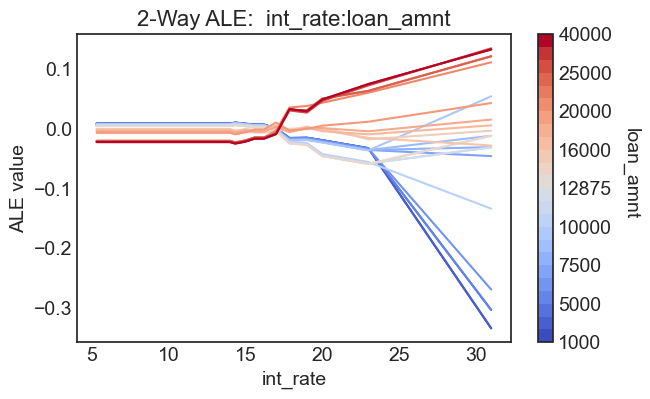

In [44]:
Image(ale_folder.joinpath('plot__int_rate__loan_amnt.png'))

The interaction serves to modify cases with high interest rates.  Higher loan amounts increase the likelihood of predicting a default.

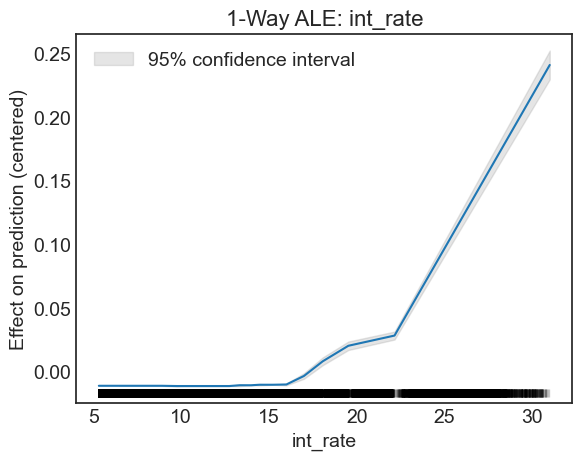

In [45]:
Image(ale_1way_folder.joinpath('plot__int_rate.png'), width=380)

It should come as no surpise that risk increases at high interest rates; this means the interest rate is doing what it should be doing.  The effect is strong, but the interaction may be stronger at high interest rates.

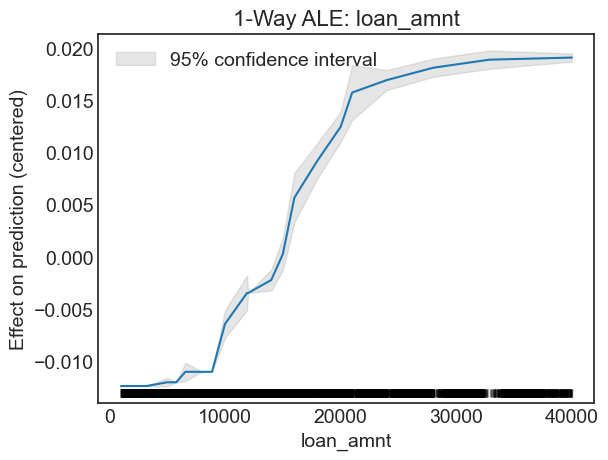

In [46]:
Image(ale_1way_folder.joinpath('plot__loan_amnt.png'), width=380)

##### Interst Rate and Income
Here we see a similar situation as with interest rate and loan amount, where the interaction affects the prediction only at high interest rates.

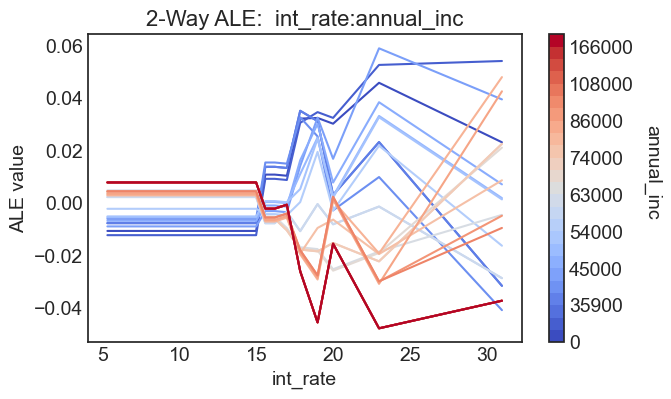

In [47]:
Image(ale_folder.joinpath('plot__int_rate__annual_inc.png'))

The interaction serves to modify cases with high interest rates.  Higher incomes decrease risk at high interest rates

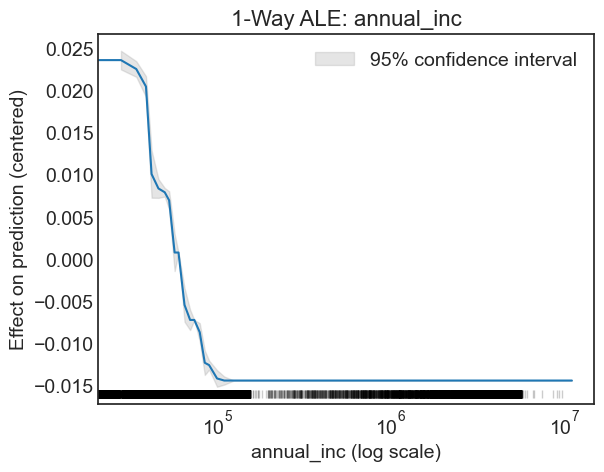

In [48]:
Image(ale_1way_folder.joinpath('plot__annual_inc.png'), width=380)

##### Annual Income and Home Ownership Status
The interaction term cancels out the home ownership advantage at higher incomes.  Basically, at a high income, it doesn't matter if you rent or own.

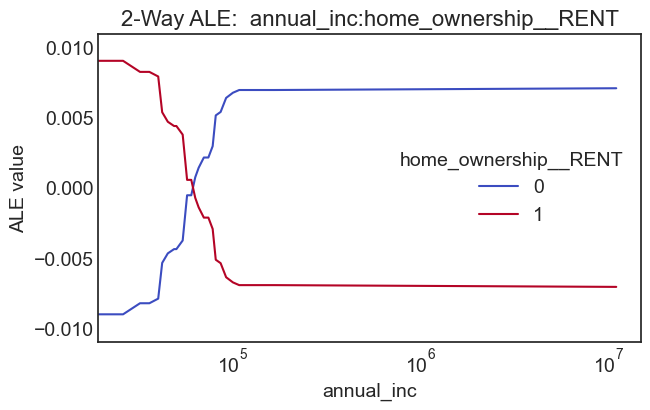

In [49]:
Image(ale_folder.joinpath('plot__annual_inc__home_ownership__RENT.png'))

The interaction shows that renting is considered less risky at higher incomes!  The main effect plot for income (see section above) shows low risk at high incomes.

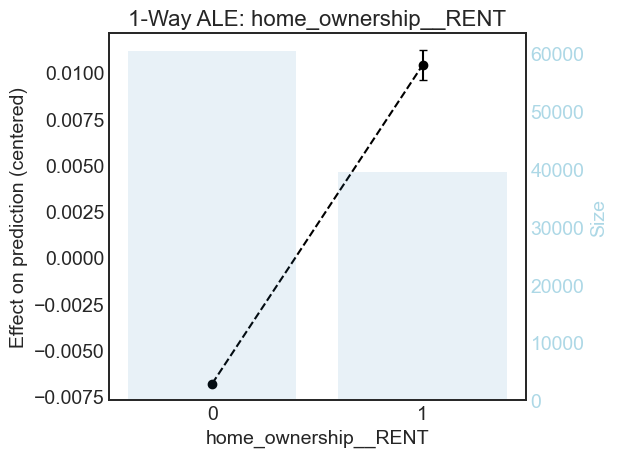

In [50]:
Image(ale_1way_folder.joinpath('plot__home_ownership__RENT.png'), width=380)

Examining the rental main effect plot helps understand the interaction plot.  Renting increases the prediction by ~0.015.  The interaction cancels this penalty at high incomes.   It appears that home ownership satus isn't a factor in model decisions for the richest buyers. The very rich can rent, buy, or live in a tree as far as the model is concerned.

##### Term and Income
This is similar to renting and income, where at high income other risk factors become unimportant.

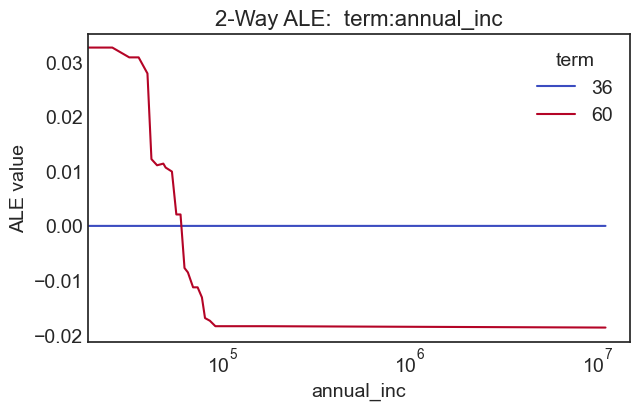

In [51]:
Image(ale_folder.joinpath('plot__term__annual_inc.png'))

The interaction serves to modify cases with high interest rates.  The term penalty is cancelled out at higher income.

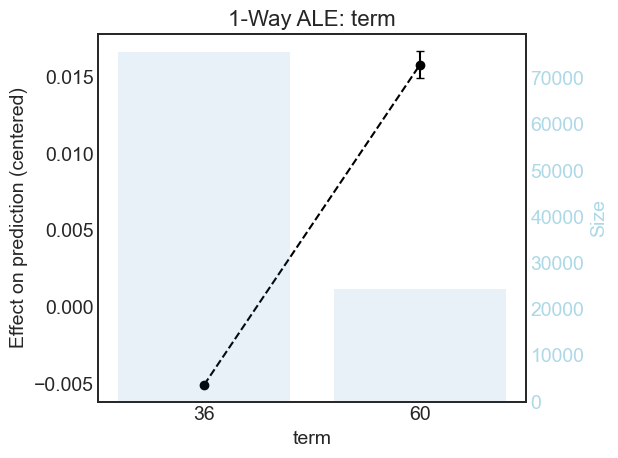

In [52]:
Image(ale_1way_folder.joinpath('plot__term.png'), width=380)

Another view of the term plot.  The reduction of effect above 100k in income mostly cancels out the increased risk of the longer term.

## Vary Sample Size

In [53]:
# Get the full training data
train_df = pd.read_parquet(Path(setup.temp_path) \
                           .joinpath('01_DATA_combined_base_train.parquet'))

In [54]:
# Function for getting the magnitudes while varying sample size
def do_ale_abs_mean_sample(X, model, features, samp_n=100):
    
    # Get a sample
    X_samp = X.sample(samp_n)
    
    # Get the ALE data. 
    try:
        this_ale = ale(X=X_samp, model=model, feature=features, plot=False)
    except:
        return None
    
    # Get counts
    this_count = ale_2way_counts(this_ale, X_samp)
    
    # Get the abs mean interaction strength
    abs_mean =  ale_2way_magnitude(this_ale, this_count)
    
    return abs_mean

In [55]:
samp_size_list = [10, 50, 100, 500, 1000]

In [56]:
%%capture

# Get the data for interest rate and term
mean_abs_list = [do_ale_abs_mean_sample(train_df[predictor_features],
                                        base_model, ['int_rate', 'term'],
                                       samp_n = n) \
    for n in samp_size_list*10]

In [57]:
mean_abs_samp_df = pd.DataFrame({'size': samp_size_list*10,
                                 'mean_abs': mean_abs_list}) \
    .groupby('size') \
    ['mean_abs'] \
    .agg(['mean', 'std'])

In [58]:
mean_abs_samp_df.to_csv(Path(setup.temp_path) \
                       .joinpath('04_REPORT_ale_magnitude_variance.csv'), index=True)

In [59]:
mean_abs_samp_df

,mean,std
size,,
10,0.006500,0.020555
50,0.009993,0.018503
100,0.016366,0.019442
500,0.012942,0.009325
1000,0.009480,0.006725


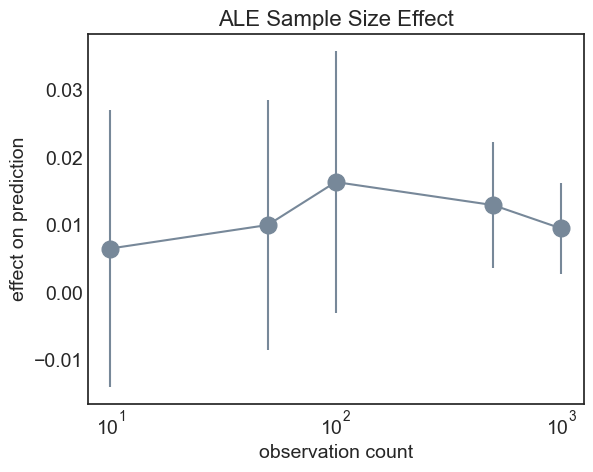

In [60]:
fig, ax = plt.subplots()
mean_abs_samp_df.plot(y='mean', yerr='std', 
                       markersize=12, style='o-', ax=ax, 
                       legend=None, color='lightslategray')
mean_abs_samp_df.plot(y='mean', markersize=12, style='o', ax=ax, 
                       legend=None, color='lightslategray')
plt.xscale('log')
#plt.axhline(y=0, color='black')
plt.title("ALE Sample Size Effect")
ax.set_xlabel('observation count')
ax.set_ylabel('effect on prediction')
plt.gcf().savefig(Path(setup.temp_path).joinpath('04_PLOT_ale_variance_with_sample_size_mean.png'),
                  bbox_inches='tight')
plt.show()